# Implementaciones Manuales de Inversión de Matrices en GPU

Este notebook contiene implementaciones de algoritmos "manuales" para la inversión de matrices, aprovechando el procesamiento en GPU con CuPy y PyTorch. Se incluyen los siguientes métodos:

1.  **Descomposición LU (con Sustitución Manual):** Utiliza la descomposición LU de las librerías, pero realiza la sustitución hacia adelante y hacia atrás de forma explícita.
2.  **Eliminación de Gauss-Jordan:** Un método directo que transforma la matriz aumentada `[A | I]` en `[I | A_inv]` mediante operaciones elementales por filas.
3.  **Descomposición de Cholesky (para Matrices SPD):** Un método eficiente para matrices simétricas definidas positivas, que invierte `L` y `L.T` manualmente.


## 1. Instalación de Librerías Necesarias

In [1]:
!pip install cupy-cuda12x
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
!pip install matplotlib seaborn

print("Instalación completada")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 125.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.7/848.7 MB 1.1 MB/s eta 0:00:00
Instalación completada


## 2. Configuración y Funciones de Utilidad

In [2]:
# Eliminar si ya existía el repo o carpeta
!rm -rf Trabajo_Final_SO
# Clonar el repositorio completo
!git clone https://github.com/brandugar/Trabajo_Final_SO.git
!mv Trabajo_Final_SO/matrices ./

Cloning into 'Trabajo_Final_SO'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 203 (delta 79), reused 179 (delta 67), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 5.87 MiB | 6.24 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [3]:
import os
print("Contenido de 'matrices/':", os.listdir("matrices"))

Contenido de 'matrices/': ['matriz_100x100_invertible.csv', 'matriz_400x400_invertible.csv', 'matriz_10x10_invertible.csv', 'matriz_250x250_invertible.csv', 'matriz_150x150_invertible.csv', 'matriz_500x500_invertible.csv', 'matriz_200x200_invertible.csv', 'matriz_300x300_invertible.csv', 'def_pos_inv', 'matriz_450x450_invertible.csv', 'matriz_50x50_invertible.csv', 'matriz_350x350_invertible.csv']


In [5]:
import cupy as cp
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Verificar disponibilidad de GPU
GPU_CUPY_DISPONIBLE = cp.cuda.is_available()
GPU_TORCH_DISPONIBLE = torch.cuda.is_available()

print(f"CuPy GPU disponible: {GPU_CUPY_DISPONIBLE}")
print(f"PyTorch GPU disponible: {GPU_TORCH_DISPONIBLE}")

def leer_matriz_csv(tamaño, carpeta="matrices"):
    """
    Lee una matriz cuadrada desde un archivo CSV en la carpeta especificada.

    """
    nombre_archivo = f"matriz_{tamaño}x{tamaño}_invertible.csv"
    ruta = os.path.join(carpeta, nombre_archivo)

    if not os.path.exists(ruta):
        raise FileNotFoundError(f"No se encontró el archivo: {ruta}")

    matriz = pd.read_csv(ruta, header=None).values.astype(np.float32)
    if matriz.shape[0] != matriz.shape[1]:
        raise ValueError("La matriz leída no es cuadrada.")
    return matriz

def medir_tiempos_por_tamaño(clase_inversor, tamanos, carpeta_matrices="matrices"):
    """
    Mide el tiempo de ejecución de una clase de inversor de matrices usando archivos CSV.
    """
    resultados = []

    for tamaño in tamanos:
        print(f"\n--- Probando matriz de {tamaño}x{tamaño} con {clase_inversor.__name__} ---")

        A_np = leer_matriz_csv(tamaño, carpeta=carpeta_matrices)
        inversor = clase_inversor()

        matriz_calentamiento = np.eye(min(tamaño, 100), dtype=np.float32)  # matriz pequeña para calentar

        try:
            for metodo in [
                'cupy_manual_lu_inverse', 'torch_manual_lu_inverse',
                'cupy_gauss_jordan_inverse', 'torch_gauss_jordan_inverse',
                'cupy_newton_inverse', 'torch_newton_inverse',
                'cupy_cholesky_inverse', 'torch_cholesky_inverse',
                'cupy_block_inverse', 'torch_block_inverse'
            ]:
                if hasattr(inversor, metodo):
                    getattr(inversor, metodo)(matriz_calentamiento)
                    break
        except ValueError as e:
            print(f"Advertencia durante calentamiento: {e}")

        if GPU_CUPY_DISPONIBLE:
            cp.cuda.runtime.deviceSynchronize()
        if GPU_TORCH_DISPONIBLE:
            torch.cuda.synchronize()

        tiempo_inicio = time.time()
        try:
            nombre_libreria = None
            A_inversa = None

            for metodo, nombre in [
                ('cupy_manual_lu_inverse', "CuPy LU Manual"),
                ('torch_manual_lu_inverse', "PyTorch LU Manual"),
                ('cupy_gauss_jordan_inverse', "CuPy Gauss-Jordan"),
                ('torch_gauss_jordan_inverse', "PyTorch Gauss-Jordan"),
                ('cupy_cholesky_inverse', "CuPy Cholesky"),
                ('torch_cholesky_inverse', "PyTorch Cholesky")

            ]:
                if hasattr(inversor, metodo):
                  try:
                    A_inversa = getattr(inversor, metodo)(A_np)
                    nombre_libreria = nombre
                    break
                  except Exception as e:
                        print(f"   Error en {nombre} con tamaño {tamaño}: {e}")
                        A_inversa = None

            if A_inversa is None:
                raise ValueError("No se encontró un método de inversión válido en la clase del inversor.")

            if GPU_CUPY_DISPONIBLE:
                cp.cuda.runtime.deviceSynchronize()
            if GPU_TORCH_DISPONIBLE:
                torch.cuda.synchronize()

            tiempo_final = time.time()
            duracion = tiempo_final - tiempo_inicio
            resultados.append({'tamaño': tamaño, 'tiempo': duracion, 'librería': nombre_libreria})


        except ValueError as e:
            print(f"Error en el benchmark para tamaño {tamaño} ({clase_inversor.__name__}): {e}")
            resultados.append({'tamaño': tamaño, 'tiempo': np.nan, 'librería': clase_inversor.__name__ + " (Error)"})

    return resultados


CuPy GPU disponible: True
PyTorch GPU disponible: True


In [6]:
def graficar_resultados_benchmark(resultados):
    """
    Grafica los resultados del benchmark de tiempos de inversión de matrices.
    """
    df = pd.DataFrame(resultados)
    df_filtrado = df.dropna(subset=['tiempo'])  # Eliminar filas con errores

    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_filtrado, x='tamaño', y='tiempo', hue='librería', marker='o')
    plt.title('Tiempo de Ejecución de Inversión de Matrices por Tamaño y Algoritmo (GPU)')
    plt.xlabel('Tamaño de la Matriz (N)')
    plt.ylabel('Tiempo (segundos)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.legend(title='Método')
    plt.tight_layout()
    plt.show()


In [7]:
def analizar_memoria_gpu():
    """
    Analiza y muestra el uso de memoria de la GPU usando CuPy y PyTorch.
    """
    print("\n--- Análisis de Memoria GPU ---")

    if GPU_CUPY_DISPONIBLE:
        print("\nAnálisis de memoria con CuPy:")
        mempool = cp.cuda.MemoryPool()
        cp.cuda.set_allocator(mempool.malloc)

        _, memoria_total = cp.cuda.Device().mem_info
        memoria_total /=  1024**3
        memoria_usada_antes = mempool.used_bytes() / 1024**3

        A_gpu = cp.random.rand(1000, 1000, dtype=cp.float32)
        _ = A_gpu @ A_gpu

        memoria_usada_despues = mempool.used_bytes() / 1024**3
        memoria_utilizada = memoria_usada_despues - memoria_usada_antes

        print(f"  Memoria total: {memoria_total:.1f} GB")
        print(f"  Usada antes del ejemplo: {memoria_usada_antes:.3f} GB")
        print(f"  Usada después del ejemplo: {memoria_usada_despues:.3f} GB")
        print(f"  Memoria utilizada por el ejemplo: {memoria_utilizada:.3f} GB")

        del A_gpu
        mempool.free_all_blocks()
        cp.cuda.runtime.deviceSynchronize()

    if GPU_TORCH_DISPONIBLE:
        print("\nAnálisis de memoria con PyTorch:")
        torch.cuda.empty_cache()

        memoria_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        memoria_usada_antes = torch.cuda.memory_allocated() / 1024**3

        A_torch = torch.rand(1000, 1000, dtype=torch.float32, device='cuda')
        _ = A_torch @ A_torch

        memoria_usada_despues = torch.cuda.memory_allocated() / 1024**3
        memoria_utilizada = memoria_usada_despues - memoria_usada_antes

        print(f"  Memoria total: {memoria_total:.1f} GB")
        print(f"  Usada antes del ejemplo: {memoria_usada_antes:.3f} GB")
        print(f"  Usada después del ejemplo: {memoria_usada_despues:.3f} GB")
        print(f"  Memoria utilizada por el ejemplo: {memoria_utilizada:.3f} GB")

        del A_torch
        torch.cuda.empty_cache()
        torch.cuda.synchronize()


## 3. Implementaciones de Algoritmos Manuales de Inversión

### 3.1. Inversión por Descomposición LU (Sustitución Manual)

In [8]:
class InversorLUGPUCuPy:
    def cupy_manual_lu_inverse(self, A):
        if not GPU_CUPY_DISPONIBLE:
            raise RuntimeError("CuPy no está disponible en GPU.")

        A_gpu = cp.asarray(A, dtype=cp.float32)
        n = A_gpu.shape[0]

        # --- LU con pivoteo parcial manual ---
        A_lu = A_gpu.copy()
        pivotes = cp.arange(n)

        for k in range(n):
            max_row = k + cp.argmax(cp.abs(A_lu[k:, k]))
            if A_lu[max_row, k] == 0:
                raise ValueError("Matriz singular detectada durante la descomposición LU.")

            if max_row != k:
                # Intercambiar filas manualmente
                temp = A_lu[k].copy()
                A_lu[k] = A_lu[max_row]
                A_lu[max_row] = temp

                temp_p = pivotes[k].copy()
                pivotes[k] = pivotes[max_row]
                pivotes[max_row] = temp_p

            for i in range(k + 1, n):
                A_lu[i, k] /= A_lu[k, k]
                A_lu[i, k+1:] -= A_lu[i, k] * A_lu[k, k+1:]

        L = cp.tril(A_lu, k=-1) + cp.eye(n, dtype=A_gpu.dtype)
        U = cp.triu(A_lu)

        I_gpu = cp.eye(n, dtype=A_gpu.dtype)
        A_inv_gpu = cp.empty_like(I_gpu)

        for j in range(n):
            e_j = I_gpu[:, j]
            b = e_j[pivotes]

            y = cp.empty_like(b)
            for i in range(n):
                suma = cp.dot(L[i, :i], y[:i]) if i > 0 else 0.0
                y[i] = b[i] - suma

            x = cp.empty_like(y)
            for i in range(n-1, -1, -1):
                suma = cp.dot(U[i, i+1:], x[i+1:]) if i < n - 1 else 0.0
                if U[i, i] == 0:
                    raise ValueError("División por cero detectada en la matriz U.")
                x[i] = (y[i] - suma) / U[i, i]

            A_inv_gpu[:, j] = x

        return A_inv_gpu

class InversorLUGPUPyTorch:
    def torch_manual_lu_inverse(self, A):
        if not GPU_TORCH_DISPONIBLE:
            raise RuntimeError("PyTorch no está disponible en GPU.")

        A_torch = torch.from_numpy(A).to(torch.float32).cuda()
        n = A_torch.shape[0]

        lu_packed, pivotes = torch.linalg.lu_factor(A_torch)

        L = torch.tril(lu_packed, diagonal=-1) + torch.eye(n, dtype=A_torch.dtype, device=A_torch.device)
        U = torch.triu(lu_packed)

        identidad_torch = torch.eye(n, dtype=A_torch.dtype, device=A_torch.device)
        A_inversa_torch = torch.empty_like(identidad_torch)

        for j in range(n):
            columna_identidad = identidad_torch[:, j]

            # Aplicar pivoteo a columna_identidad (b_modificada)
            b_modificada = columna_identidad.clone()
            pivotes_cpu = pivotes.cpu().numpy()
            for k in range(n):
                pivote_actual = pivotes_cpu[k] - 1  # Convertir a índice base 0
                if pivote_actual != k:
                    temp = b_modificada[k].clone()
                    b_modificada[k] = b_modificada[pivote_actual].clone()
                    b_modificada[pivote_actual] = temp

            # Sustitución hacia adelante (L @ y = P^T @ e_j)
            y = torch.empty_like(columna_identidad)
            for i in range(n):
                suma = torch.dot(L[i, :i], y[:i]) if i > 0 else 0.0
                y[i] = b_modificada[i] - suma

            # Sustitución hacia atrás (U @ x = y)
            x = torch.empty_like(columna_identidad)
            for i in range(n - 1, -1, -1):
                suma = torch.dot(U[i, i+1:], x[i+1:]) if i < n - 1 else 0.0
                if U[i, i] == 0:
                    raise ValueError("División por cero detectada: matriz posiblemente singular.")
                x[i] = (y[i] - suma) / U[i, i]

            A_inversa_torch[:, j] = x

        return A_inversa_torch.cpu()


### 3.2. Inversión por Eliminación de Gauss-Jordan

In [9]:
class InversorGaussJordanGPUCuPy:
    def cupy_gauss_jordan_inverse(self, A):
        if not GPU_CUPY_DISPONIBLE:
            raise RuntimeError("CuPy no está disponible en GPU.")

        A_gpu = cp.asarray(A, dtype=cp.float32)
        n = A_gpu.shape[0]

        identidad_gpu = cp.eye(n, dtype=cp.float32)
        M = cp.concatenate((A_gpu, identidad_gpu), axis=1)

        for j in range(n):
            fila_pivote = j + cp.argmax(cp.abs(M[j:, j]))

            if M[fila_pivote, j] == 0:
                raise ValueError("La matriz es singular o casi singular, no se puede invertir con Gauss-Jordan.")

            # Intercambio de filas
            M[j], M[fila_pivote] = M[fila_pivote].copy(), M[j].copy()

            # Normalizar fila pivote
            elemento_pivote = M[j, j]
            M[j] = M[j] / elemento_pivote

            # Eliminar otras filas
            for i in range(n):
                if i != j:
                    factor = M[i, j]
                    M[i] = M[i] - factor * M[j]

        A_inversa_gpu = M[:, n:]
        return A_inversa_gpu

class InversorGaussJordanGPUPyTorch:
    def torch_gauss_jordan_inverse(self, A):
        if not GPU_TORCH_DISPONIBLE:
            raise RuntimeError("PyTorch no está disponible en GPU.")

        A_torch = torch.from_numpy(A).to(torch.float32).cuda()
        n = A_torch.shape[0]

        identidad_torch = torch.eye(n, dtype=torch.float32, device=A_torch.device)
        M = torch.cat((A_torch, identidad_torch), dim=1)

        for j in range(n):
            valor_pivote, desplazamiento = torch.max(torch.abs(M[j:, j]), dim=0)
            fila_pivote = j + desplazamiento.item()

            if M[fila_pivote, j] == 0:
                raise ValueError("La matriz es singular o casi singular, no se puede invertir con Gauss-Jordan.")

            # Intercambiar filas
            M[[j, fila_pivote]] = M[[fila_pivote, j]]

            # Normalizar fila pivote
            elemento_pivote = M[j, j]
            M[j] = M[j] / elemento_pivote

            # Eliminar otras filas
            for i in range(n):
                if i != j:
                    factor = M[i, j]
                    M[i] = M[i] - factor * M[j]

        A_inversa_torch = M[:, n:]
        return A_inversa_torch.cpu()


### 3.3. Inversión por Descomposición de Cholesky

In [10]:
class InversorCholeskyGPUCuPy:
    def cupy_cholesky_inverse(self, A):
        if not GPU_CUPY_DISPONIBLE:
            raise RuntimeError("CuPy no está disponible en GPU.")

        A_gpu = cp.asarray(A, dtype=cp.float32)
        n = A_gpu.shape[0]

        # Descomposición A = L @ L.T (matriz SPD)
        L = cp.linalg.cholesky(A_gpu)

        L_inv = cp.empty_like(L)
        identidad_gpu = cp.eye(n, dtype=A_gpu.dtype)

        # Resolver L @ x = e_j para cada columna
        for j in range(n):
            e_j = identidad_gpu[:, j]
            x_j = cp.empty_like(e_j)

            for i in range(n):
                suma = cp.sum(L[i, :i] * x_j[:i]) if i > 0 else 0.0
                if L[i, i] == 0:
                    raise ValueError("División por cero detectada: matriz singular o fallo en Cholesky.")
                x_j[i] = (e_j[i] - suma) / L[i, i]

            L_inv[:, j] = x_j

        # A⁻¹ = (L⁻¹)ᵗ @ L⁻¹
        L_inv_traspuesta = L_inv.T
        A_inversa_gpu = cp.dot(L_inv_traspuesta, L_inv)

        return A_inversa_gpu

class InversorCholeskyGPUPyTorch:
    def torch_cholesky_inverse(self, A):
        if not GPU_TORCH_DISPONIBLE:
            raise RuntimeError("PyTorch no está disponible en GPU.")

        A_torch = torch.from_numpy(A).to(torch.float32).cuda()
        n = A_torch.shape[0]
        identidad = torch.eye(n, dtype=A_torch.dtype, device=A_torch.device)

        # Probar con múltiples valores de epsilon
        for epsilon in [1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]:
            try:
                A_reg = A_torch + epsilon * identidad
                L = torch.linalg.cholesky(A_reg)
                break
            except RuntimeError as e:
                ultima_excepcion = e
        else:
            print(f"   Error en PyTorch Cholesky: Fallo incluso con ε=100")
            raise ValueError(f"Fallo en Cholesky incluso tras regularización. Último error: {ultima_excepcion}")

        L_inv = torch.empty_like(L)

        for j in range(n):
            e_j = identidad[:, j]
            x_j = torch.empty_like(e_j)

            for i in range(n):
                suma = torch.dot(L[i, :i], x_j[:i]) if i > 0 else 0.0
                x_j[i] = (e_j[i] - suma) / L[i, i]

            L_inv[:, j] = x_j

        A_inv = torch.matmul(L_inv.T, L_inv)
        return A_inv.cpu()


## 4. Benchmarking y Comparación


--- Ejecutando Pruebas de Rendimiento ---

### CuPy LU Manual ###

--- Probando matriz de 100x100 con InversorLUGPUCuPy ---

--- Probando matriz de 200x200 con InversorLUGPUCuPy ---

--- Probando matriz de 300x300 con InversorLUGPUCuPy ---

--- Probando matriz de 400x400 con InversorLUGPUCuPy ---

--- Probando matriz de 500x500 con InversorLUGPUCuPy ---

### CuPy Gauss-Jordan ###

--- Probando matriz de 100x100 con InversorGaussJordanGPUCuPy ---

--- Probando matriz de 200x200 con InversorGaussJordanGPUCuPy ---

--- Probando matriz de 300x300 con InversorGaussJordanGPUCuPy ---

--- Probando matriz de 400x400 con InversorGaussJordanGPUCuPy ---

--- Probando matriz de 500x500 con InversorGaussJordanGPUCuPy ---

### PyTorch LU Manual ###

--- Probando matriz de 100x100 con InversorLUGPUPyTorch ---

--- Probando matriz de 200x200 con InversorLUGPUPyTorch ---

--- Probando matriz de 300x300 con InversorLUGPUPyTorch ---

--- Probando matriz de 400x400 con InversorLUGPUPyTorch ---

--- Proba

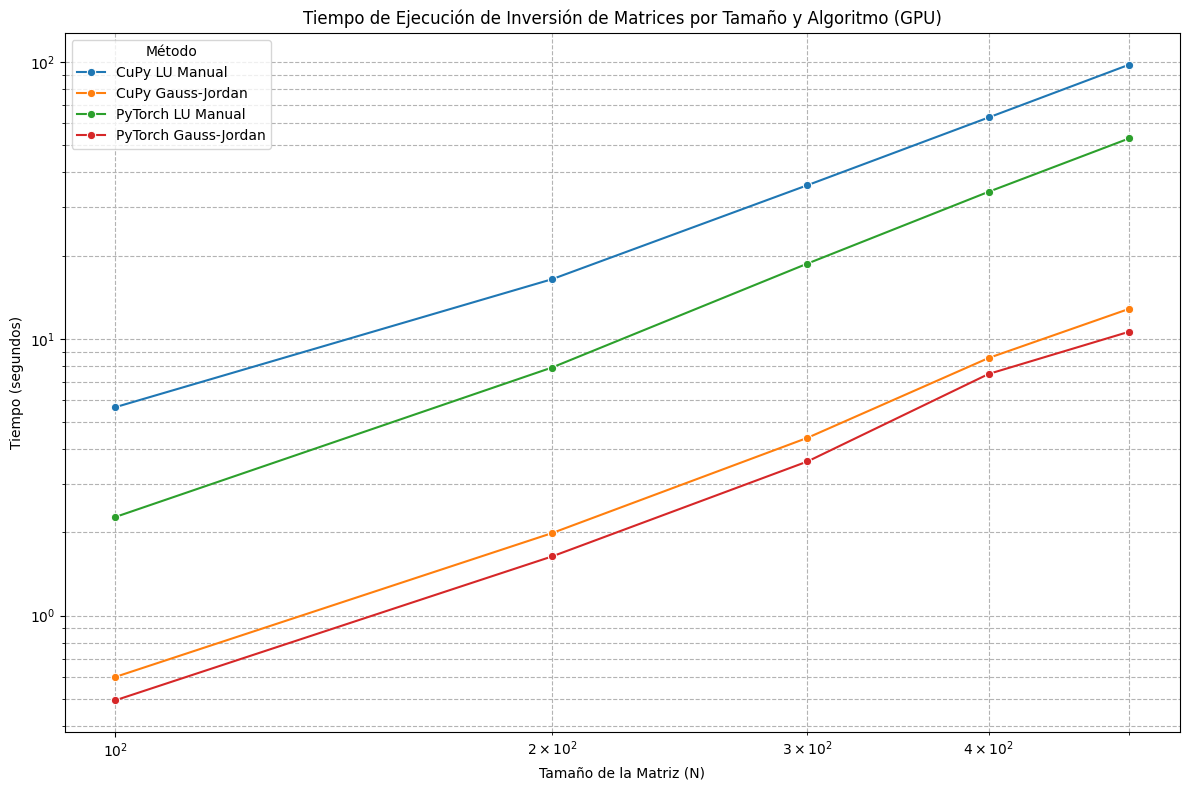

In [11]:
# Tamaños de matrices disponibles
tamaños_disponibles = [100, 200, 300, 400, 500]

# Lista para almacenar todos los resultados
todos_los_resultados = []

print("\n--- Ejecutando Pruebas de Rendimiento ---")

if GPU_CUPY_DISPONIBLE:
    print("\n### CuPy LU Manual ###")
    todos_los_resultados.extend(medir_tiempos_por_tamaño(InversorLUGPUCuPy, tamaños_disponibles))

    print("\n### CuPy Gauss-Jordan ###")
    todos_los_resultados.extend(medir_tiempos_por_tamaño(InversorGaussJordanGPUCuPy, tamaños_disponibles))


if GPU_TORCH_DISPONIBLE:
    print("\n### PyTorch LU Manual ###")
    todos_los_resultados.extend(medir_tiempos_por_tamaño(InversorLUGPUPyTorch, tamaños_disponibles))

    print("\n### PyTorch Gauss-Jordan ###")
    todos_los_resultados.extend(medir_tiempos_por_tamaño(InversorGaussJordanGPUPyTorch, tamaños_disponibles))


print("\n--- Pruebas Completadas ---")

graficar_resultados_benchmark(todos_los_resultados)

In [12]:
def obtener_dataframe_resultados(resultados):
    """
    Devuelve un DataFrame ordenado con los resultados del benchmark.
    """
    df = pd.DataFrame(resultados)
    df = df.dropna(subset=["tiempo"])  # Eliminar entradas con error
    df = df.sort_values(by=["librería", "tamaño"])  # Ordenar por librería y tamaño
    df.reset_index(drop=True, inplace=True)
    return df

In [13]:
df_resultados = obtener_dataframe_resultados(todos_los_resultados)
print(df_resultados)

    tamaño     tiempo              librería
0      100   0.600719     CuPy Gauss-Jordan
1      200   1.987367     CuPy Gauss-Jordan
2      300   4.390265     CuPy Gauss-Jordan
3      400   8.530182     CuPy Gauss-Jordan
4      500  12.840536     CuPy Gauss-Jordan
5      100   5.663764        CuPy LU Manual
6      200  16.419461        CuPy LU Manual
7      300  35.893740        CuPy LU Manual
8      400  63.060311        CuPy LU Manual
9      500  97.844172        CuPy LU Manual
10     100   0.494634  PyTorch Gauss-Jordan
11     200   1.636727  PyTorch Gauss-Jordan
12     300   3.606114  PyTorch Gauss-Jordan
13     400   7.468879  PyTorch Gauss-Jordan
14     500  10.613580  PyTorch Gauss-Jordan
15     100   2.272295     PyTorch LU Manual
16     200   7.877842     PyTorch LU Manual
17     300  18.703206     PyTorch LU Manual
18     400  33.986567     PyTorch LU Manual
19     500  52.987177     PyTorch LU Manual


#Lectura de matrices SPD y procesamiento con Cholesky

In [14]:
def leer_matriz_definida_positiva_csv(tamaño, carpeta="matrices/def_pos_inv"):
    """
    Lee una matriz definida positiva desde la carpeta especificada, con nombres tipo:
    matriz_100x100_dpi.csv

    Parámetros:
        tamaño (int): Tamaño de la matriz cuadrada.
        carpeta (str): Carpeta donde se encuentran las matrices SPD.

    Retorna:
        np.ndarray: Matriz cuadrada de tipo float32.
    """
    nombre_archivo = f"matriz_{tamaño}x{tamaño}_dpi.csv"
    ruta = os.path.join(carpeta, nombre_archivo)

    if not os.path.exists(ruta):
        raise FileNotFoundError(f"No se encontró el archivo: {ruta}")

    matriz = pd.read_csv(ruta, header=None).values.astype(np.float32)

    if matriz.shape[0] != matriz.shape[1]:
        raise ValueError("La matriz leída no es cuadrada.")

    return matriz


In [15]:
def medir_tiempos_cholesky_spd(clase_inversor, tamanos, carpeta_matrices="matrices/def_pos_inv"):
    """
    Mide el tiempo de ejecución del inversor de matrices definida positiva (SPD)
    usando Cholesky y archivos CSV con sufijo '_dpi.csv'.
    """
    resultados = []

    for tamaño in tamanos:
        print(f"\n--- Probando SPD {tamaño}x{tamaño} con {clase_inversor.__name__} ---")

        A_np = leer_matriz_definida_positiva_csv(tamaño, carpeta=carpeta_matrices)
        inversor = clase_inversor()

        if GPU_CUPY_DISPONIBLE:
            cp.cuda.runtime.deviceSynchronize()
        if GPU_TORCH_DISPONIBLE:
            torch.cuda.synchronize()

        tiempo_inicio = time.time()
        try:
            nombre_libreria = None
            A_inversa = None

            for metodo, nombre in [
                ('cupy_cholesky_inverse', "CuPy Cholesky"),
                ('torch_cholesky_inverse', "PyTorch Cholesky")
            ]:
                if hasattr(inversor, metodo):
                    try:
                        A_inversa = getattr(inversor, metodo)(A_np)
                        nombre_libreria = nombre
                        break
                    except Exception as e:
                        print(f"   Error en {nombre} con tamaño {tamaño}: {e}")
                        A_inversa = None

            if A_inversa is None:
                raise ValueError("No se pudo invertir la matriz SPD.")

            if GPU_CUPY_DISPONIBLE:
                cp.cuda.runtime.deviceSynchronize()
            if GPU_TORCH_DISPONIBLE:
                torch.cuda.synchronize()

            tiempo_final = time.time()
            duracion = tiempo_final - tiempo_inicio
            resultados.append({'tamaño': tamaño, 'tiempo': duracion, 'librería': nombre_libreria})

        except ValueError as e:
            print(f"Error en SPD {tamaño} ({clase_inversor.__name__}): {e}")
            resultados.append({'tamaño': tamaño, 'tiempo': np.nan, 'librería': clase_inversor.__name__ + " (Error)"})

    return resultados


In [16]:
tamaños_spd = [100, 200, 300, 400, 500]

# Resultados solo de matrices SPD
resultados_spd = []

if GPU_CUPY_DISPONIBLE:
    print("\n### Cholesky CuPy con SPD ###")
    resultados_spd.extend(medir_tiempos_cholesky_spd(InversorCholeskyGPUCuPy, tamaños_spd))

if GPU_TORCH_DISPONIBLE:
    print("\n### Cholesky PyTorch con SPD ###")
    resultados_spd.extend(medir_tiempos_cholesky_spd(InversorCholeskyGPUPyTorch, tamaños_spd))

# Si quieres unirlos al resto:
todos_los_resultados.extend(resultados_spd)



### Cholesky CuPy con SPD ###

--- Probando SPD 100x100 con InversorCholeskyGPUCuPy ---

--- Probando SPD 200x200 con InversorCholeskyGPUCuPy ---

--- Probando SPD 300x300 con InversorCholeskyGPUCuPy ---

--- Probando SPD 400x400 con InversorCholeskyGPUCuPy ---

--- Probando SPD 500x500 con InversorCholeskyGPUCuPy ---

### Cholesky PyTorch con SPD ###

--- Probando SPD 100x100 con InversorCholeskyGPUPyTorch ---

--- Probando SPD 200x200 con InversorCholeskyGPUPyTorch ---

--- Probando SPD 300x300 con InversorCholeskyGPUPyTorch ---

--- Probando SPD 400x400 con InversorCholeskyGPUPyTorch ---

--- Probando SPD 500x500 con InversorCholeskyGPUPyTorch ---


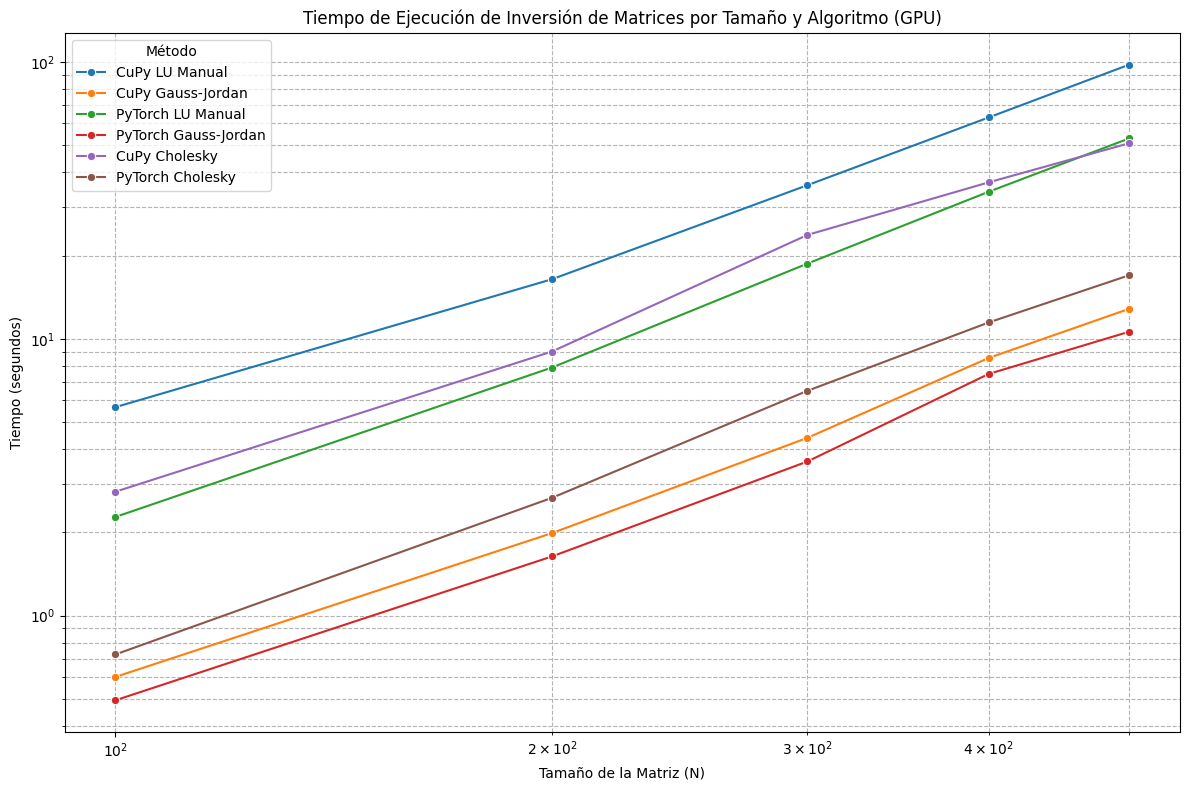

In [17]:
graficar_resultados_benchmark(todos_los_resultados)

In [18]:
df_resultados = obtener_dataframe_resultados(todos_los_resultados)
print(df_resultados)

    tamaño     tiempo              librería
0      100   2.803164         CuPy Cholesky
1      200   9.000503         CuPy Cholesky
2      300  23.734057         CuPy Cholesky
3      400  36.758364         CuPy Cholesky
4      500  50.892854         CuPy Cholesky
5      100   0.600719     CuPy Gauss-Jordan
6      200   1.987367     CuPy Gauss-Jordan
7      300   4.390265     CuPy Gauss-Jordan
8      400   8.530182     CuPy Gauss-Jordan
9      500  12.840536     CuPy Gauss-Jordan
10     100   5.663764        CuPy LU Manual
11     200  16.419461        CuPy LU Manual
12     300  35.893740        CuPy LU Manual
13     400  63.060311        CuPy LU Manual
14     500  97.844172        CuPy LU Manual
15     100   0.724225      PyTorch Cholesky
16     200   2.665254      PyTorch Cholesky
17     300   6.491568      PyTorch Cholesky
18     400  11.459819      PyTorch Cholesky
19     500  16.975703      PyTorch Cholesky
20     100   0.494634  PyTorch Gauss-Jordan
21     200   1.636727  PyTorch G

## 5. Análisis de Memoria GPU

In [50]:
analizar_memoria_gpu()


--- Análisis de Memoria GPU ---

Análisis de memoria con CuPy:
  Memoria total: 14.7 GB
  Usada antes del ejemplo: 0.000 GB
  Usada después del ejemplo: 0.007 GB
  Memoria utilizada por el ejemplo: 0.007 GB

Análisis de memoria con PyTorch:
  Memoria total: 14.7 GB
  Usada antes del ejemplo: 0.008 GB
  Usada después del ejemplo: 0.015 GB
  Memoria utilizada por el ejemplo: 0.007 GB


## Conclusión

Este notebook te permite experimentar con implementaciones más fundamentales de algoritmos de inversión de matrices en un entorno de GPU. Observarás que, a pesar de usar GPUs, los métodos implementados con bucles explícitos en Python (como Gauss-Jordan y la sustitución triangular manual en LU/Cholesky) son considerablemente más lentos que las funciones optimizadas de las librerías. Esto subraya la importancia de las implementaciones a nivel de C++/CUDA que las librerías como CuPy y PyTorch utilizan internamente para maximizar el rendimiento de la GPU.

